In [16]:
import os
import os.path as osp
import cv2
import itertools as it
import numpy as np
import random
from torchvision import transforms, io
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

In [2]:
def apply_blur(images, kernel_size, sigma):
    blur_fn = transforms.GaussianBlur(kernel_size, sigma = (sigma, sigma))
    return list(map(blur_fn, images))

In [119]:
# assumes gaussian blur has been applied to images already
def get_sub_images(images, f_sub, upscale_factor):
    """
        images: list of tensors of dimension (3, h, w) 
        f_sub: expected dimension of square sub-images
        upscale_factor: amount to downsize the HR image/ upscale the 
            sub-sampled images by

        requires: upscale_factor must evenly divide f_sub

        Returns list of sub-images, list of (3, f_sub, f_sub) tensors,
        formed from patches of images in 'images'. 
        Sub-images are f_sub x f_sub.
        To form sub-images, patches of an image are sub-sampled by the upscaling factor
        and then interpolated by the same factor. 

    """
    assert f_sub%upscale_factor == 0, "upscale_factor should divide final sub-image length, f_sub"

    patches = []

    for image in images:
        # image = blurred_images[5]
        depth, height, width = image.shape
        for i in range(0, height//f_sub):
            for j in range(0, width//f_sub):
                temp = image[:, i*f_sub:(i+1)*f_sub, j*f_sub:(j+1)*f_sub]
                # temp = temp.to(torch.int) # I guess this has to happen for color to show?
                patches.append(temp)
    
    sub_sampled = [] # just for testing
    sub_images = []
    for patch in patches:
        downsampled = patch[:, ::upscale_factor, ::upscale_factor]
        sub_sampled.append(downsampled)

        # print(downsampled.shape)
        # add dimension for batch size, since interpolate seems wants n,c specified
        downsampled = torch.unsqueeze(downsampled, 0)
        upsampled = nn.functional.interpolate(downsampled, 
                                              scale_factor=(upscale_factor, upscale_factor), 
                                              mode='bicubic', align_corners=True)
        del_batch_dim = upsampled[0, :, :, :]
        sub_images.append(del_batch_dim)
        
    
    return patches, sub_images, sub_sampled

/Users/sarahwang/Documents/cv-project/2016
['img_010_SRF_3_HR.png', 'img_002_SRF_3_HR.png', 'img_005_SRF_3_HR.png', 'img_004_SRF_3_HR.png', 'img_003_SRF_3_HR.png', 'img_011_SRF_3_HR.png', 'img_009_SRF_3_HR.png', 'img_008_SRF_3_HR.png', 'img_001_SRF_3_HR.png', 'img_006_SRF_3_HR.png', 'img_013_SRF_3_HR.png', 'img_014_SRF_3_HR.png', 'img_012_SRF_3_HR.png', 'img_007_SRF_3_HR.png']


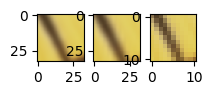

In [141]:
def process_imgs(source, destination, f_sub, upscale_factor):
    """
        Returns the sub-images to be used for training and 
    """
    
    # obtains array of images (tensor)
    img_names = os.listdir(source)
    images = [io.read_image(osp.join(source, name)) 
              for name in img_names]
    
    print(img_names)

    # gaussian blur
    blurred_images = apply_blur(images, 9, 2)

    # obtain sub-images
    patches, sub_images, sub_sampled = get_sub_images(blurred_images, 33, 3)

    patches_imshow = [patch.to(torch.int) for patch in patches] # this makes it show up for imshow

    # plt.plot()
    # plt.imshow(torch.einsum('ijk->jki', patches_imshow[200])) 


    # imgs = [torch.einsum('ijk->jki', img) for img in patches[5]]
    # print(len(imgs))
    n = 1200
    imgs = [patches[n], sub_images[n], sub_sampled[n]]
    for i, img in enumerate(imgs):
        img = img.to(torch.int)
        plt.subplot(1, len(imgs)*3, i+1)
        plt.imshow(torch.einsum('ijk->jki', img)) 
    

    # put sub-images in destination

# main

root = os.getcwd()
print(root)

source = "data/set14"
destination = "data/train_sub_images"
f_sub = 33
upscale_factor = 3

source = osp.join(root, source)
destination = osp.join(root, destination)
process_imgs(source, destination, f_sub, upscale_factor)


/Users/sarahwang/Documents/cv-project/2016
['img_010_SRF_3_HR.png', 'img_002_SRF_3_HR.png', 'img_005_SRF_3_HR.png', 'img_004_SRF_3_HR.png', 'img_003_SRF_3_HR.png', 'img_011_SRF_3_HR.png', 'img_009_SRF_3_HR.png', 'img_008_SRF_3_HR.png', 'img_001_SRF_3_HR.png', 'img_006_SRF_3_HR.png', 'img_013_SRF_3_HR.png', 'img_014_SRF_3_HR.png', 'img_012_SRF_3_HR.png', 'img_007_SRF_3_HR.png']
3


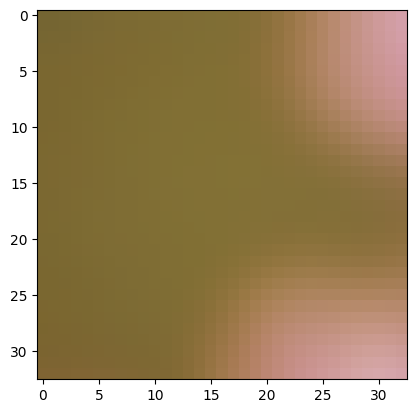

In [104]:
# main

root = os.getcwd()
print(root)

source = "data/set14"
destination = "data/train_sub_images"
f_sub = 33
upscale_factor = 3

source = osp.join(root, source)
destination = osp.join(root, destination)
process_imgs(source, destination, f_sub, upscale_factor)

(3, 3, 3)
[[0 0 0]
 [0 0 0]
 [0 1 4]]
uint8
<class 'numpy.ndarray'>
(3, 3, 3)
[[0 1 2]
 [3 4 5]
 [6 7 8]]
uint8
<class 'numpy.ndarray'>


[]

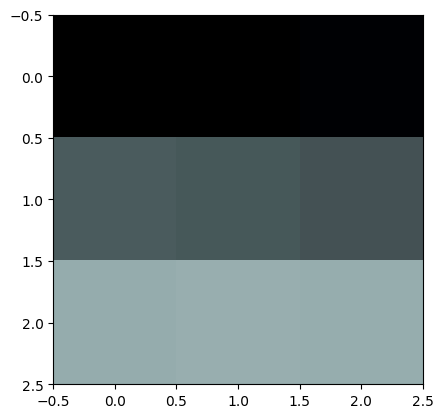

In [64]:
# testing image capabilities

image = cv2.imread("/Users/sarahwang/Documents/cv-project/2016/data/set14/img_004_SRF_3_HR.png")

image = image[:3, :3, :]
print(image.shape)
print(image[0])
print(image.dtype)
print(type(image))
b = np.arange(0, 27).reshape((3,3,3)).astype(np.uint8)

c = np.array([
[[0, 0, 0],
 [0, 0, 0],
 [0, 1, 4]],
[[74, 91, 93],
 [70, 88, 89],
 [68, 81, 84]]
    ,
[[149, 172, 173],
 [152, 174, 175],
 [150, 173, 174]]
])
print(b.shape)
print(b[0])
print(b.dtype)
print(type(b))
plt.subplot(1, 1, 1)
plt.imshow(c)
plt.plot()